# Анализ результатов А/В тестирования. Проверка эффективности нового алгоритма рекомендации постов.

### Входные данные:
**Время эксперимента:** с 2024-05-03 по 2024-05-09 включительно  
**Группа 1** - контрольная  
**Группа 2** - экспериментальная  
**Основная гипотеза** - новый алгоритм во группе 2 приведет к увеличению CTR. 

Считаем, что система сплитования работает корректно, результат А/А теста удовлетворительный.

### Задача: проанализиоровать данные A/B теста
- Выбрать метод анализа и сравнить CTR в двух группах:
    - t-тест, 
    - тест Манна-Уитни, 
    - Пуассоновский бутстреп, 
    - t-тест на сглаженном ctr (α=5), 
    - t-тест и тест Манна-Уитни поверх бакетного преобразования
- Сравнить данные этими тестами. Посмотрить на распределения, понять, почему тесты сработали именно так.
- Написать рекомендацию, стоит ли раскатывать новый алгоритм на всех новых пользователей.

### Шаг 1.  
Сформулируем нулевую и альтернативную гипотезы и зафиксируем уровень значимости:
- H0: CTR_exp_group_2 = CTR_exp_group_1
- H1: CTR_exp_group_2 != CTR_exp_group_1
- alpha = 0.05  

### Шаг 2.
Подключимся к БД, выгрузим в датафрейм пользователей за период проведения А/B теста и рассчитаем ключевую метрику CTR для каждого пользователя.

In [1]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
import scipy.stats as stats
import numpy as np
import os

In [3]:
# подключаемся к схеме данных ленты новостей
connection = {
    'host': os.environ.get('HOST'),
    'database': os.environ.get('DATABASE'),
    'user': os.environ.get('USER_NAME'),
    'password': os.environ.get('PASSWORD')
}

# Рассчитаем CTR для каждого пользователя и сгруппируем по пользователяю и группе
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2024-05-03' and '2024-05-09'
    and exp_group in (1,2)
GROUP BY exp_group, user_id
"""

ctr_df = ph.read_clickhouse(q, connection=connection)

In [4]:
# Посмотрим, что получилось
ctr_df.head()

,exp_group,user_id,likes,views,ctr
0,1,109963,3,15,0.200000
1,1,26117,32,141,0.226950
2,1,138232,18,73,0.246575
3,1,18392,7,32,0.218750
4,1,26295,39,141,0.276596


In [5]:
# Проверим кол-во записей в каждой группе
ctr_df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
1,10020,10020,10020,10020
2,9877,9877,9877,9877


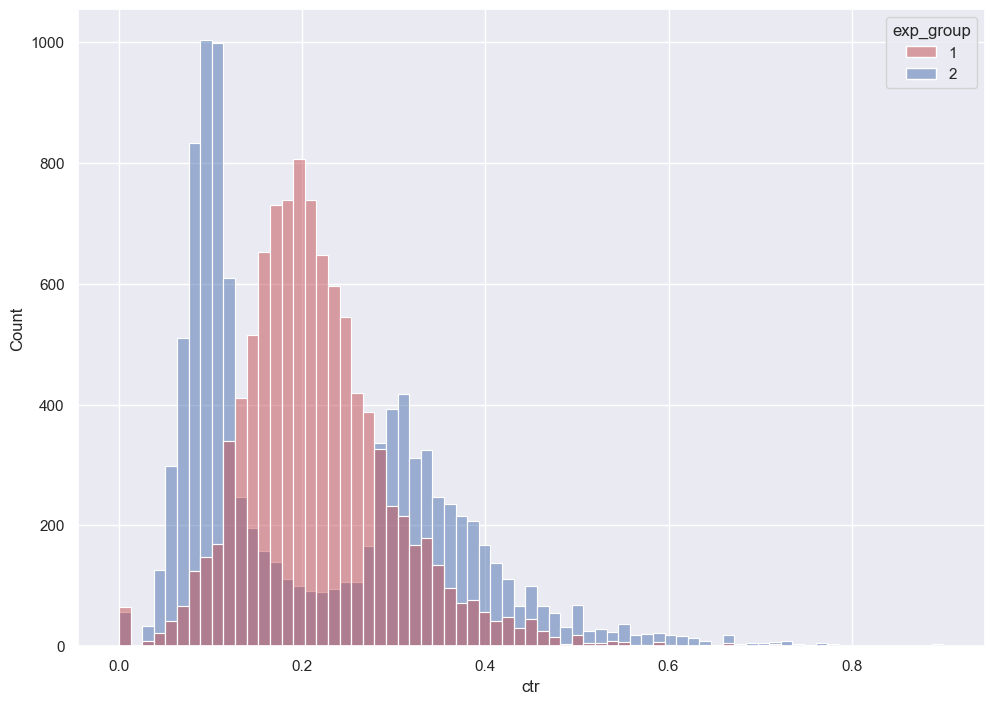

In [6]:
# Визуализируем распределение CTR для двух групп
sns.set(rc={'figure.figsize':(11.7,8.27)})
groups = sns.histplot(data = ctr_df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Видим, что распределение CTR в 1 группе похоже на нормальное, а во 2 группе - нет.

### Шаг 3. A/B тест

### 1. t-тест

In [7]:
stats.ttest_ind(ctr_df[ctr_df.exp_group == 1].ctr,
                ctr_df[ctr_df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.4051491913112757, pvalue=0.685373331140751)

In [7]:
print(ctr_df[ctr_df.exp_group == 1].ctr.mean(), ctr_df[ctr_df.exp_group == 2].ctr.mean())

0.216773994120072 0.2161016893237817


**Вывод:**  
p-value > 0.05, поэтому t-тест не опровергает нулевую гипотезу, т.е средние CTR равны с допустимой погрешностью. 

### 2. Манна-Уитни

In [8]:
stats.mannwhitneyu(ctr_df[ctr_df.exp_group == 1].ctr, 
                   ctr_df[ctr_df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=55189913.0, pvalue=4.632205841806026e-45)

**Вывод:**  
p-value < 0.05 и стремится к нулю, значит, тест Манна-Уитни опровергает нулевую гипотезу и видит разницу между CTR в выборках.   

### 3. t-тест на сглаженном CTR

In [9]:
# Определим функцию сглаживания Лапласа
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [10]:
# Рассчитаем глобальный CTR для каждой группы
global_ctr_1 = ctr_df[ctr_df.exp_group == 1].likes.sum()/ctr_df[ctr_df.exp_group == 1].views.sum()
global_ctr_2 = ctr_df[ctr_df.exp_group == 2].likes.sum()/ctr_df[ctr_df.exp_group == 2].views.sum()

# Копируем данные из датафрейма для группы 1 и 2 по-отдельности
group1 = ctr_df[ctr_df.exp_group == 1].copy()
group2 = ctr_df[ctr_df.exp_group == 2].copy()

<Axes: xlabel='ctr', ylabel='Count'>

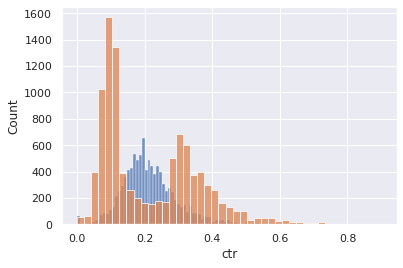

In [11]:
# Визуализируем распределение оригинального CTR 
sns.histplot(group1.ctr, kde = False)
sns.histplot(group2.ctr, kde = False)

<Axes: xlabel='smothed_ctr', ylabel='Count'>

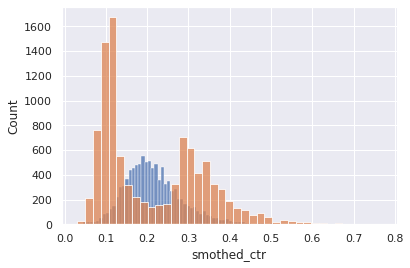

In [12]:
# Зададим гиперпараметр а = 5
a = 5

# Применим сглаживание CTR на группу 1
group1['smothed_ctr'] = ctr_df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, a), axis=1)
# Применим сглаживание CTR на группу 2
group2['smothed_ctr'] = ctr_df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_2, a), axis=1)

# Визуализируем распределение сглаженного CTR
sns.histplot(group1.smothed_ctr, kde = False)
sns.histplot(group2.smothed_ctr, kde = False)

In [13]:
# Применим t-тест 
stats.ttest_ind(group1.smothed_ctr,
                group2.smothed_ctr,
                equal_var=False)

Ttest_indResult(statistic=1.9460491517027683, pvalue=0.05166679015318526)

**Вывод:**  
Результат похож на t-тест с оригинальным CTR.
p-value > 0.05, значит t-тест не опровергает нулевую гипотезу, сглаженные CTR равны с допустимой погрешностью. 

### 4. Пуассоновский бутстреп

In [14]:
# Определим функцию бутстреп
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

<Axes: ylabel='Count'>

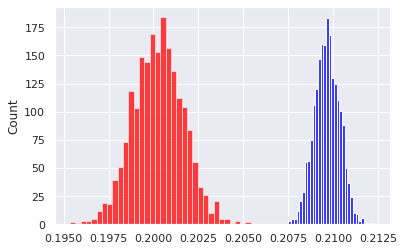

In [15]:
# Запишем просмотры и лайки каждой группы
likes1 = ctr_df[ctr_df.exp_group == 1].likes.to_numpy()
views1 = ctr_df[ctr_df.exp_group == 1].views.to_numpy()
likes2 = ctr_df[ctr_df.exp_group == 2].likes.to_numpy()
views2 = ctr_df[ctr_df.exp_group == 2].views.to_numpy()

# Применим бутстреп, получим выборки из глобальных CTR 1 и 2 групп
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

# Визуализируем распределение
sns.histplot(ctr1, color='blue') # контроль
sns.histplot(ctr2, color='red') # таргет

<Axes: ylabel='Count'>

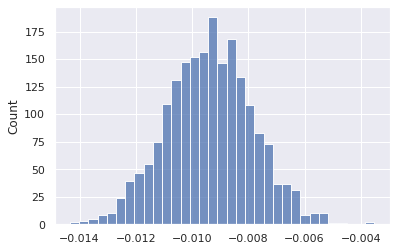

In [17]:
# Разница между глобальными CTR (CTR_target - CTR_control)
sns.histplot(ctr2-ctr1)

**Вывод:**  
Распределение не пересекает 0. 
Разница получилась отрицательная - это значит, что в группе 2, где проводился эксперимент, CTR снизился.
Нулевая гипотеза не подтвердилась.

### 5. Бакетное преобразование

In [18]:
q_bucket = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2024-05-03' and '2024-05-09'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

bucket_df = ph.read_clickhouse(q_bucket, connection=connection)

In [19]:
bucket_df.head()

,exp_group,bucket,bucket_ctr
0,1,0,0.200592
1,2,0,0.196510
2,1,1,0.208799
3,2,1,0.210375
4,1,2,0.204632


<Axes: xlabel='bucket_ctr', ylabel='Count'>

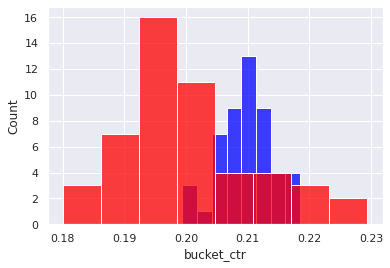

In [20]:
# Визуализируем бакетные CTR
sns.histplot(bucket_df[bucket_df.exp_group == 1].bucket_ctr, color='blue')
sns.histplot(bucket_df[bucket_df.exp_group == 2].bucket_ctr, color='red')

In [21]:
# Применим тест Манна-Уитни
stats.mannwhitneyu(bucket_df[bucket_df.exp_group == 1].bucket_ctr, 
                   bucket_df[bucket_df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1997.0, pvalue=2.6576427804010095e-07)

In [22]:
# Применим t-тест
stats.ttest_ind(bucket_df[bucket_df.exp_group == 1].bucket_ctr, 
                bucket_df[bucket_df.exp_group == 2].bucket_ctr, 
                equal_var = False)

Ttest_indResult(statistic=5.614819358149381, pvalue=4.592644937473873e-07)

In [23]:
print(bucket_df[bucket_df.exp_group == 1].bucket_ctr.mean(), bucket_df[bucket_df.exp_group == 2].bucket_ctr.mean())

0.20969361570538578 0.2004567038618196


**Вывод:**  
Оба теста видят отличия в CTR после бакетного преобразования. CTR таргета 2 группы ниже, чем CTR контрольной 1 группы.

### Результат:   
- t-test и t-test на сглаженном CTR не опровергают нулевую гипотезу и не видят разницу между средним CTR. Скорее всего это ошибка, которая обусловлена неравномерным распределением CTR группы 2.
- тест Манна-Уитни, Пуассоновский бетстреп и t-test поверх бакетного преобразования видят разницу в CTR, причем CTR_target < CTR_control. Это значит, что новый алгоритм рекомендаций постов не увеличил лайки относительно просмотров. Не рекомендуется раскатывать новый алгоритм на всех пользователей.